# Feature Importance outline

### Feature importance
- Introduction and motivation for discussing feature importance:
    - Define feature importance (using a fuzzy definition -- rank features by how much they "*contribute*" to the prediction function).
    - Feature importance measures are frequently reported, in part because many packages make them easy to compute/visualize.
        - Show google image search results
    - They can be potentially misleading. Important to understand potential pitfalls.
    - Utility of feature importance:
        - Feature selection -- use votes example from original Breiman Random Forests paper.
        - Sanity checking models/detecting leakage (TODO: see if I can find an example where feature importance show some feature unexpectedly popping since due to leakage).
- Framing feature importance methods:
    - Divide into two classes:
        - Methods that exploit the structure of the prediction function or learning algorithm (call these function-specific).
        - Methods that are agnostic (i.e. can be applied to any black box prediction function).
- Function-specific methods:
    - Mean decrease impurity:
        - Frame running example:
            - Introduce the iris dataset and classification problem.
            - graphviz some shallow tree on the iris dataset (see below).
            - **Ask students** which features seem "important" as a turn and talk. Have some subset share answers without explanation.
        - Introduce MDE:
        $$Imp(X_m) = \frac{1}{N_T}\sum_T\sum_{t \in T:v(s_t)=X_m}p(t)\Delta i(s_t,t)$$
        - Show from scratch implimentation (see lab_outline_and_mean_decrease_impurity.ipynb).
        - Show correspondance with sklearn's implementation.
        - **Ask students** what other classifiers we could extend this too (Random Forests/GBMs) and how (averaging).
        - Show RF importance for the iris problem.
        - Say there are variants:
            - Example: CART implementation exposes a knob to add weight for use of a feature as a surrogate split.
    - Absolute coefficients in a linear model:
        - **Ask students** how we could determine feature importance in a linear model.
        - Show some example (TODO) of extracting absolute $\beta$s from a model.
        - **Ask students**: How would this interact with preprocessing?
- Model agnostic methods:
    - Frame the general problem for global feature importance:
        - Another framing of feature importance -- we are trying to identify how much each feature independently contributes to risk reduction in the learned model.
        - **Ask students**: How could we do this for an arbitrary black box prediction function?
        - **Hint (fragment slide)**: Imagine you were tasked with constructing a synthetic dataset with an *unimportant* feature -- how could you construct it? Given this insight, what operation could be applied to a feature that would be expected to have (a) no impact on empirical risk for unimportant features, and (b) decrease performance for important featuers?
    - Permutation importance:
        - Give Breimans original OOB permutation feature importance.
        - Say that the OOB version exploits bootstrapping in RFs, but can just use a validation set.
        - Show example (using ELI5 implementation) over the iris problem.
        - **Ask students**: This method permute features to get a measure of feature importance. Let's extend this concept a bit -- how could permuting the target be useful in interogating the performance of a model?
        - http://jmlr.csail.mit.edu/papers/volume11/ojala10a/ojala10a.pdf
        - For fun show this using permutation_test_score for the iris data.
- Pitfalls:
    - Correlated features
        - Show the GBM feature importance for duplicated or highly correlated features (TODO: think about which is better for this purpose) (from lab_outline_and_mean_decrease_impurity.ipynb).
        - **Ask students**: Interpret this plot. What can we say about the features/model?
        - Show same plot for enet, and ask same question -- hopefully students will recall that (at least in the context of linear models) our conversations about feature correlation.
        - Show the elastnic net bound result as review, and primer to think about correlation issues.
        - Show correlation matrix/matrices (duplicated and/or highly correlated), and known data generating process.
        - **Ask students**: Given what we know about (i) linear methods, and (ii) trees, what does this show us about potential pitfalls in interpreting feature importance plots?
        - **Ask students**: How would this impact SelectFromModel feature selection procedures (ala sklearn) which select the most important features from a model based on either absolute coefficients or feature importance scores? Why might we want to use RFE?

### PDPs
- Motivation and introduction to partial dependence plots
    - Imagine we have a subset of features we think are important.
        - This could be based on "feature importance" scores or coefficients, or other reasons (i.e. prior knowledge/research questions/etc.).
    - We may want to dig deeper to explain the relationship between our predictions and these features.
        - **Ask students**: Why? If we have MDI feature importance scores in hand, what do we not know?
            - Directionality:
                - Note in reality we probably have complex, non-monotonic relationships
                - However even if we have a monotonic relationship, or even linear, our MDI wouldn't give any indication on the direction -- obviously weights in a linear model would.
    - Partial dependence plots let us dig deeper and visualize the dependence of our prediction function (i.e. predict/predict_proba) on one or two of these features. Can't easily go higher-dimensional (Why not? Can't visualize).
    - Show basic math (marginal and empirical estimate -- see https://arxiv.org/pdf/1309.6392.pdf for useful framing).

- PDP examples:
    - Show sklearn example (see partial_dependence.ipynb).
    - **Ask students**: What does this plot show? How do we interpret it? 
- PDP pitfalls:
    - Show the flat partial dependence plot from (https://arxiv.org/pdf/1309.6392.pdf) reproduced in partial_dependence.ipynb.
    - **Ask students**: What does this plot show?
    - Follow up with big reveal:
        - Show data generating process and X plot.
    - **Ask students**: What does this teach us? When might PDPs fail?
    - Share "not too strong" quote from Friedman's original work (see partial_dependence.ipynb).
    
### Additional material
- If 100 minutes allows (what is your opinion, David?), the next steps would be:
    - Generate the ICE plot for the X data (figure 2 in https://arxiv.org/pdf/1309.6392.pdf)
    - Take this  as a launching point for point out that our progression has been from:
        - Global measures (feature importance) that don't necessarily describe structure (even directionality) of a relationship between a feature and target.
        - Marginalized measures showing average relationship between one or two features and the target.
        - Data-instance specific feature importance plots showing the importance of a feature, for each data instance, fixing all other feature values.
    - We can follow this thread it's conclusion -- attempting to develop model explanations that show the relative contribution of each feature to predictions locally (i.e. in the neighborhood of a specific instance):
        - LIME paper (https://arxiv.org/abs/1602.04938) as one example.


# Feature importance outline for trees

This notebook outlines some concepts and code for mean decrease impurity and permutation feature importance.

In [1]:
from IPython import display
def hide_code_in_slideshow():
    import os
    uid = os.urandom(8).encode("hex")
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;

            while (!p.hasClass("cell")) {
                p=p.parent();

                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

In [2]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

# Lab outline (for this notebook)

### 1. What is feature imortance and why do we want to explore it?
- Intepret/interogate models:
    - This is not causal, but can still be useful.
    - As a decidely non-causal example, perhaps looking at feature importance will give you some insight into leakage if a feature pops unexpectedly (you always want to sanity check your prediction functions).
    - Alternatively, it might help you with feature selection (i.e. `SelectFromModel`).
- Feature selection:
    - Show permutation example from original Random Forest paper on voting patterns -- using a single feature OOB performance is almost as good.
    - Danger!!!
        - (From eli5 docs) Permutation importance should be used for feature selection with care (like many other feature importance measures). For example, if several features are correlated, and the estimator uses them all equally, permutation importance can be low for all of these features: dropping one of the features may not affect the result, as estimator still has an access to the same information from other features. So if features are dropped based on importance threshold, such correlated features could be dropped all at the same time, regardless of their usefulness. RFE and alike methods (as opposed to single-stage feature selection) can help with this problem to an extent.
        - Show this with ElasticNet, since there we can revisit our theorem on correlated features.
- We can think about two general sets of feature importance measures:
    - Model-based feature importance measures. These are importance measures that we can compute based on the structure of the prediction function/and-or learning algorithm. We have these for tree-based models and linear models (weights/mean decrease impurity in a tree -- shown in this notebook).
    - Generalized feature imortance framework -- can compute a "feature importance" measure for an arbitrary (black box) function. We'll discuss permutation importance and partial dependence plots.

### Approach 1: Mean decrease impurity (and coeficients in a linear model).

- See https://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf equation 2
- Ask *what prediction functions would support this definition of feature importance?* (A: tree based)
- Work through the sklearn iris example below.
- Then ask *when might this fail* as a turn and talk.
- Finally show the correlated features example below for both elastic net (circle back to our theorem) and GBM, and hit (i.e. screenshot) the Eli5 warning above.


### Approach 2: Permutation Importance

- Can use permutations to get a handle on the importance of a feature:
    - From original Breiman paper:
    Suppose there are $M$ input variables. After each tree is constructed, the values of the $m^{th}$ variable in the out-of-bag examples are randomly permuted and the out-of-bag data is run down the corresponding tree. The classification given for each $x_n$ that is out of bag is saved. This is repeated for $m = 1, 2,\cdots, M$. At the end of the run, the plurality of out-of-bag class votes for $x_n$ with the $m^{th}$ variable noised up is compared with the true class label of $x_n$ to give a misclassification rate.
    - Show application to a single tree using http://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html
    - Ask *based on the tree, why would permuting petal length lead to a larger decrease in performance?* -- answer:  See first split

##### Extensions
- Note we can extend this idea from permutations over features to permutations over the target to get a handle on the significance of a test score -- see http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.permutation_test_score.html


##### Pros:
- Fully general (not we're not making any assumptions on the algorithm except for OOB sample (in Breiman paper) -- which is just to exploit OOB structure of RF -- could just use a validation set).
- Computationally expensive relative to model-specific (extract betas).




In [6]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [1]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(iris.data, iris.target)

Some notes for speaker view.

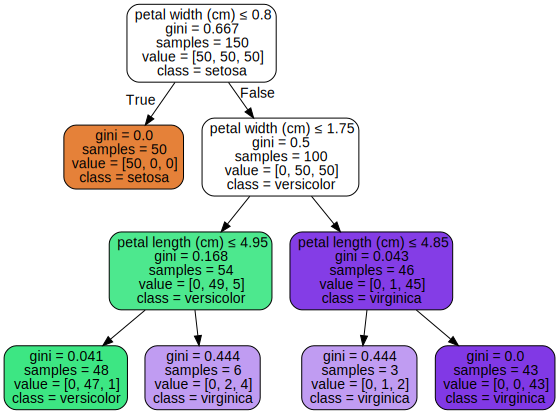

In [18]:
hide_code_in_slideshow()


dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [12]:
import pandas as pd
pd.DataFrame({'Feature': iris.feature_names,
              'Importance':clf.feature_importances_})

,Feature,Importance
0,sepal length (cm),0.000000
1,sepal width (cm),0.000000
2,petal length (cm),0.053936
3,petal width (cm),0.946064


Recall a tree is built from a learning sample of size $N$ drawn from
$P(X_1,\cdots, X_p, Y)$ using a recursive procedure which identifies at each node $t$ the split $s_t = s^∗$ for which the partition of the $N_t$ node samples into $t_L$ and $t_R$ maximizes the decrease
$$\Delta i(s, t) = i(t) − p_Li(t_L) − p_Ri(t_R)$$
of some impurity measure $i(t)$ (e.g., the Gini index, the Shannon entropy, or the variance of $Y$).

This suggests a "Mean Decrease Impurity" importance measure, here shown for all trees in forest with $T$ trees:
$$Imp(X_m) = \frac{1}{N_T}\sum_T\sum_{t \in T:v(s_t)=X_m}p(t)\Delta i(s_t,t)$$
Note $p(t) = N_t/N$ is the proportion of samples reaching node $t$ and $v(s_t)$ is the variable used in split $s_t$.

Let's calculate this explicitly for sepal length. 

In [9]:
from collections import defaultdict
import numpy as np

In [10]:
def feature_importance_single_tree(tree, feature_names=iris.feature_names):
    total_samples = np.sum(tree.weighted_n_node_samples)
    feature_importance = defaultdict(float)
    # See sklearn example plot_unveil_tree_structure.html
    is_leaf = (tree.children_right == tree.children_left)
    for ix in range(len(is_leaf)):
        if not is_leaf[ix]:
            impurity = tree.impurity[ix]
            split_feature = tree.feature[ix]
            num_at_node = tree.weighted_n_node_samples[ix]

            # Get left child contribution
            left_child = tree.children_left[ix]
            left_decrease = tree.weighted_n_node_samples[left_child]/num_at_node * \
                                tree.impurity[left_child]

            # Get right child contribution
            right_child = tree.children_right[ix]
            right_decrease = tree.weighted_n_node_samples[right_child]/num_at_node * \
                                tree.impurity[right_child]

            delta = impurity - left_decrease - right_decrease
            
            feature_importance[feature_names[split_feature]] \
                += num_at_node / total_samples * delta
    norm = np.sum(feature_importance.values())
    feature_importance = {key: val/norm for key, val in feature_importance.items()}
    return feature_importance

In [11]:
feature_importance_single_tree(clf.tree_)

{'petal length (cm)': 0.053936331199339008,
 'petal width (cm)': 0.94606366880066095}

Note we can easily extend this to ensemble of trees :)

In [8]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100)

In [9]:
forest.fit(iris.data, iris.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
pd.DataFrame({'Feature': iris.feature_names,
              'Importance':forest.feature_importances_})

,Feature,Importance
0,sepal length (cm),0.096164
1,sepal width (cm),0.025964
2,petal length (cm),0.449715
3,petal width (cm),0.428157


In [11]:
forest_importance = defaultdict(float)
for tree in forest.estimators_:
    tree_importance = feature_importance_single_tree(tree.tree_)
    
    for key, val in tree_importance.items():
        forest_importance[key] += val
forest_importance = {key:val/len(forest.estimators_)\
                     for key, val in forest_importance.items()}

In [12]:
forest_importance

{'petal length (cm)': 0.44971549580809772,
 'petal width (cm)': 0.42815674228676259,
 'sepal length (cm)': 0.096163772856607432,
 'sepal width (cm)': 0.025963989048532574}

Another approach is permutation importance, per the Breiman paper -- here we just permute each feature in turn and see how the accuracy degrades. In the original paper, this was done over the OOB sample, but we can also do it for a test set (here we just use the training data as a toy examle). Note we don't have to use accuracy -- any score is fine -- but our sklearn decision tree score method reurns accuracy.

In [13]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clf)
perm.fit(iris.data, iris.target)
output = eli5.show_weights(perm)

In [14]:
import pandas as pd
pd.DataFrame({'Feature': iris.feature_names, 'Importance':perm.feature_importances_})

,Feature,Importance
0,sepal length (cm),0.000000
1,sepal width (cm),0.000000
2,petal length (cm),0.105333
3,petal width (cm),0.525333


In [15]:
perm = PermutationImportance(forest)
perm.fit(iris.data, iris.target)
output = eli5.show_weights(perm)

In [16]:
pd.DataFrame({'Feature': iris.feature_names, 'Importance':perm.feature_importances_})

,Feature,Importance
0,sepal length (cm),0.012000
1,sepal width (cm),0.013333
2,petal length (cm),0.216000
3,petal width (cm),0.185333


# When this might fail

Let's look at an example with correlated features using both elastic net and feature importance (from a GBM).

In [206]:
size = 1000
X1 = np.random.uniform(-10,10,size)
Z1 = np.random.uniform(-10,10,size)
X2 = Z1 + np.random.normal(0,2,size)
X3 = Z1 + np.random.normal(0,2,size)
X4 = Z1 + np.random.normal(0,2,size)

In [207]:
def actual_function(X1,Z1):
    return -1./2.*X1 + Z1 + np.random.normal(0,1,len(X1))

Here ask *which feature is more important?*

In [208]:
Y = actual_function(X1,Z1)

In [209]:
feats = np.stack([X1,X2,X3,X4]).T

In [210]:
pd.DataFrame(feats).corr()

,0,1,2,3
0,1.000000,0.031228,0.039624,0.051494
1,0.031228,1.000000,0.882811,0.880844
2,0.039624,0.882811,1.000000,0.887544
3,0.051494,0.880844,0.887544,1.000000


In [211]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(feats,Y,test_size=0.2,
                                                   random_state=1345134)

In [212]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [213]:
reg = GradientBoostingRegressor(n_estimators=200,subsample=0.5)
grid = GridSearchCV(reg,
                    param_grid={
                        'max_leaf_nodes':[10,25,50],
                        'min_samples_leaf':[10,25,50]
                    }, n_jobs=5,cv=5)

In [214]:
grid.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=0.5, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'max_leaf_nodes': [10, 25, 50], 'min_samples_leaf': [10, 25, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [215]:
grid.best_estimator_.feature_importances_

array([ 0.28739322,  0.22013966,  0.23425943,  0.25820768])

In [216]:
grid.score(test_X,test_y)

0.92819576926216174

## Compare with elastic net

In [217]:
from sklearn.linear_model import ElasticNetCV

In [218]:
enet = ElasticNetCV()
enet.fit(train_X,train_y)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [219]:
enet.score(test_X,test_y)

0.94159265017916305

In [221]:
enet.coef_

array([-0.49495418,  0.29880776,  0.35362496,  0.305685  ])

In [222]:
enet.coef_[1:].sum()

0.95811772091903613

Ask the questions:
- How are these similar/different?
    - Coefficients give us a sign -- importance does not.
    - Both show X1 as more important than the highly correlated X2..X4
    - This (could be) a problem if you were to:
        - Try to use these feature importance measures to try to explain the prediction function (i.e. saying the most important feature is X1 is misleading -- the partial of the true conditional expectation function is 2x greater for the latent variable Z1 than for the observed variable X1).
        - Using `SelectFromModel` for feature selection -- imagine extending this example to construct a more pathalogical case where some `SelectFromModel` threshold excludes a set of highly correlated but informative variables (note you would want to avoid this by doing some search/optimization over the `SelectFromModel` threshold hyperparameter).
       

# Now with identical features

In [172]:
feats = np.stack([X1,Z1,Z1,Z1]).T

In [173]:
pd.DataFrame(feats).corr()

,0,1,2,3
0,1.000000,0.001165,0.001165,0.001165
1,0.001165,1.000000,1.000000,1.000000
2,0.001165,1.000000,1.000000,1.000000
3,0.001165,1.000000,1.000000,1.000000


In [174]:
grid.fit(feats, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=0.5, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'max_leaf_nodes': [10, 25, 50], 'min_samples_leaf': [10, 25, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [175]:
grid.best_estimator_.feature_importances_

array([ 0.50083372,  0.16263472,  0.17598738,  0.16054417])